In [12]:
# sklearn 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_roc_curve

# nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tree import Tree
import nltk

# scipy
from scipy.sparse import csr_matrix, hstack, lil_matrix

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import random
import string 
import pickle
import time
import warnings

sns.set()
warnings.filterwarnings('ignore')

## Exploratory data analysis

In [46]:
train = pd.read_csv('/content/drive/MyDrive/snli_1.0/snli_1.0_train.txt', sep='\t')
dev = pd.read_csv('/content/drive/MyDrive/snli_1.0/snli_1.0_dev.txt', sep='\t')
test = pd.read_csv('/content/drive/MyDrive/snli_1.0/snli_1.0_test.txt', sep='\t')

In [47]:
train_data = pd.concat([train.sentence1, train.sentence2, train.gold_label, train.sentence1_parse, train.sentence2_parse], axis=1)
train_data = train_data[train_data.gold_label != '-']

dev_data = pd.concat([dev.sentence1, dev.sentence2, dev.gold_label, dev.sentence1_parse, dev.sentence2_parse], axis=1)
dev_data = dev_data[dev_data.gold_label != '-']

test_data = pd.concat([test.sentence1, test.sentence2, test.gold_label, test.sentence1_parse, test.sentence2_parse], axis=1)
test_data = test_data[test_data.gold_label != '-']

del train, dev, test

In [48]:
train_data.columns, dev_data.columns, test_data.columns = (['sent1', 'sent2', 'label', 'sent1_pos', 'sent2_pos'],) * 3

In [49]:
print(train_data.isnull().sum(), '\n', dev_data.isnull().sum(), '\n', test_data.isnull().sum())

sent1        0
sent2        6
label        0
sent1_pos    0
sent2_pos    0
dtype: int64 
 sent1        0
sent2        0
label        0
sent1_pos    0
sent2_pos    0
dtype: int64 
 sent1        0
sent2        0
label        0
sent1_pos    0
sent2_pos    0
dtype: int64


In [50]:
train_data.dropna(axis=0, inplace=True)
train_data.reset_index(drop=True, inplace=True)
dev_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [52]:
X_train = train_data[['sent1', 'sent2', 'sent1_pos', 'sent2_pos']]
y_train = train_data[['label']]

X_dev = dev_data[['sent1', 'sent2', 'sent1_pos', 'sent2_pos']]
y_dev = dev_data[['label']]

X_test = test_data[['sent1', 'sent2', 'sent1_pos', 'sent2_pos']]
y_test = test_data[['label']]

In [54]:
LABELS = {'contradiction': 0,
          'neutral': 1,
          'entailment': 2}

for y in [y_train, y_dev, y_test]:
    y['label_num'] = y.loc[:, 'label'].apply(lambda x: LABELS[x])

In [55]:
y_train

,label,label_num
0,neutral,1
1,contradiction,0
2,entailment,2
3,neutral,1
4,entailment,2
...,...,...
549356,contradiction,0
549357,neutral,1
549358,neutral,1
549359,contradiction,0


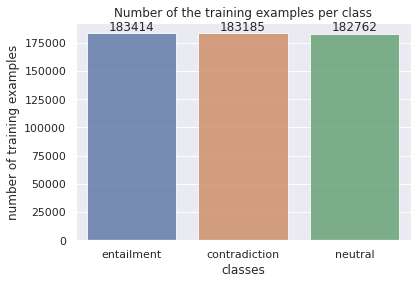

In [56]:
label, count = y_train.label.value_counts().index, y_train.label.value_counts().values
ax = sns.barplot(label, count, alpha=0.8)
ax.set_title('Number of the training examples per class')
ax.set_xlabel('classes')
ax.set_ylabel('number of training examples')
rects = ax.patches
for rect, label in zip(rects, count):
    rec_height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, rec_height + 5, label, ha='center', va='bottom')

In [21]:
def preprocessing(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

for df in [X_train, X_dev, X_test]:
    df.loc[:, 'sent1'] = df.loc[:, 'sent1'].apply(lambda x: preprocessing(x))
    df.loc[:, 'sent2'] = df.loc[:, 'sent2'].apply(lambda x: preprocessing(x))

Гистограммы с количеством слов в каждом предложении (в первом и втором)


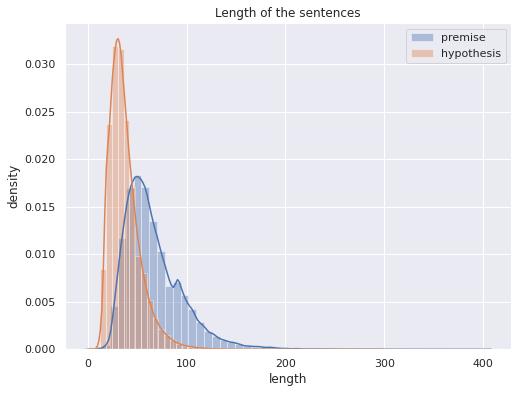

In [22]:
for data in [train_data, dev_data, test_data]:
    data['sent1_length'] = data.loc[:, 'sent1'].str.len()
    data['sent2_length'] = data.loc[:, 'sent2'].str.len()

plt.figure(figsize=(8, 6))
sns.distplot(train_data['sent1_length'], label = 'premise')
sns.distplot(train_data['sent2_length'], label = 'hypothesis')
plt.title('Length of the sentences')
plt.xlabel('length')
plt.ylabel('density')
plt.legend()

In [23]:
train_data['sent1_length'].mean() / train_data['sent2_length'].mean()

1.7685256252296053

In [24]:
gps = train_data.groupby(['label'])
for i in gps.groups.keys():
    print('-' * 50)
    group = gps.get_group(i)
    print('Average lenth of the sentence 1 of class "{}" is {}'.format(i, group['sent1_length'].mean()))
    print('Average lenth of the sentence 2 of class "{}" is {}'.format(i, group['sent2_length'].mean()))

--------------------------------------------------
Average lenth of the sentence 1 of class "contradiction" is 66.27405628190081
Average lenth of the sentence 2 of class "contradiction" is 36.83222971313153
--------------------------------------------------
Average lenth of the sentence 1 of class "entailment" is 66.2736105204619
Average lenth of the sentence 2 of class "entailment" is 33.51080070223647
--------------------------------------------------
Average lenth of the sentence 1 of class "neutral" is 66.27548396274936
Average lenth of the sentence 2 of class "neutral" is 42.09570370208249


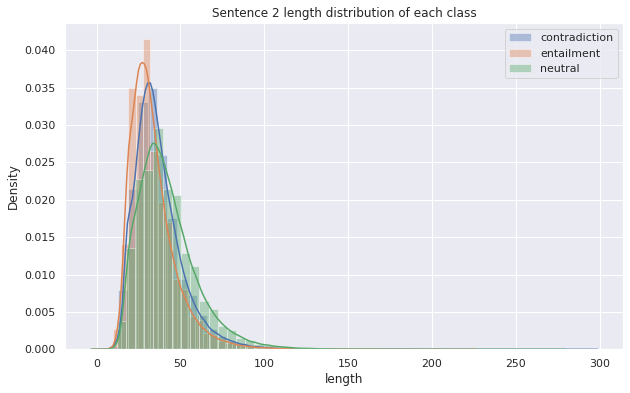

In [25]:
plt.figure(figsize=(10, 6))
gps = train_data.groupby(['label'])
for i in gps.groups.keys():
    group = gps.get_group(i)
    sns.distplot(group['sent2_length'], label = i)
    plt.xlabel('length')
    plt.title('Sentence 2 length distribution of each class')
plt.legend()

In [26]:
def get_tags(x):
    tags = []
    t = Tree.fromstring(x)
    for i in range(len(t.leaves())):
        idx = t.leaf_treeposition(i)
        subt = t[idx[:-1]]
        tags.append(subt.label())
    return tags

for df in [X_train, X_dev, X_test]:
    df['sent1_tags'] = df.loc[:, 'sent1_pos'].apply(lambda x: get_tags(x))
    df['sent2_tags'] = df.loc[:, 'sent2_pos'].apply(lambda x: get_tags(x))

In [27]:
X_train.head()

,sent1,sent2,sent1_pos,sent2_pos,sent1_tags,sent2_tags
0,a person on a horse jumps over a broken down a...,a person is training his horse for a competition,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,"[DT, NN, IN, DT, NN, VBZ, IN, DT, JJ, JJ, NN, .]","[DT, NN, VBZ, VBG, PRP$, NN, IN, DT, NN, .]"
1,a person on a horse jumps over a broken down a...,a person is at a diner ordering an omelette,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,"[DT, NN, IN, DT, NN, VBZ, IN, DT, JJ, JJ, NN, .]","[DT, NN, VBZ, IN, DT, NN, ,, VBG, DT, NN, .]"
2,a person on a horse jumps over a broken down a...,a person is outdoors on a horse,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,"[DT, NN, IN, DT, NN, VBZ, IN, DT, JJ, JJ, NN, .]","[DT, NN, VBZ, RB, ,, IN, DT, NN, .]"
3,children smiling and waving at camera,they are smiling at their parents,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VB...,"[NNP, VBG, CC, VBG, IN, NN]","[PRP, VBP, VBG, IN, PRP$, NNS]"
4,children smiling and waving at camera,there are children present,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NN...,"[NNP, VBG, CC, VBG, IN, NN]","[EX, VBP, NNS, RB]"


In [105]:
y_train.head()

,label,label_num
0,neutral,1
1,contradiction,0
2,entailment,2
3,neutral,1
4,entailment,2


In [29]:
def get_tag_counts(cls_name):
    group = gp.get_group(cls_name)
    gp_tags = pd.concat((group['sent1_tags'], group['sent2_tags']), axis=0)
    tags = []
    for row in gp_tags:
        tags += row
    tag_counts = pd.Series(tags)
    return tag_counts

df = pd.concat([X_train, y_train], axis=1)
gp = df.groupby(['label'])
e_tags = get_tag_counts('entailment')
c_tags = get_tag_counts('contradiction')
n_tags = get_tag_counts('neutral')

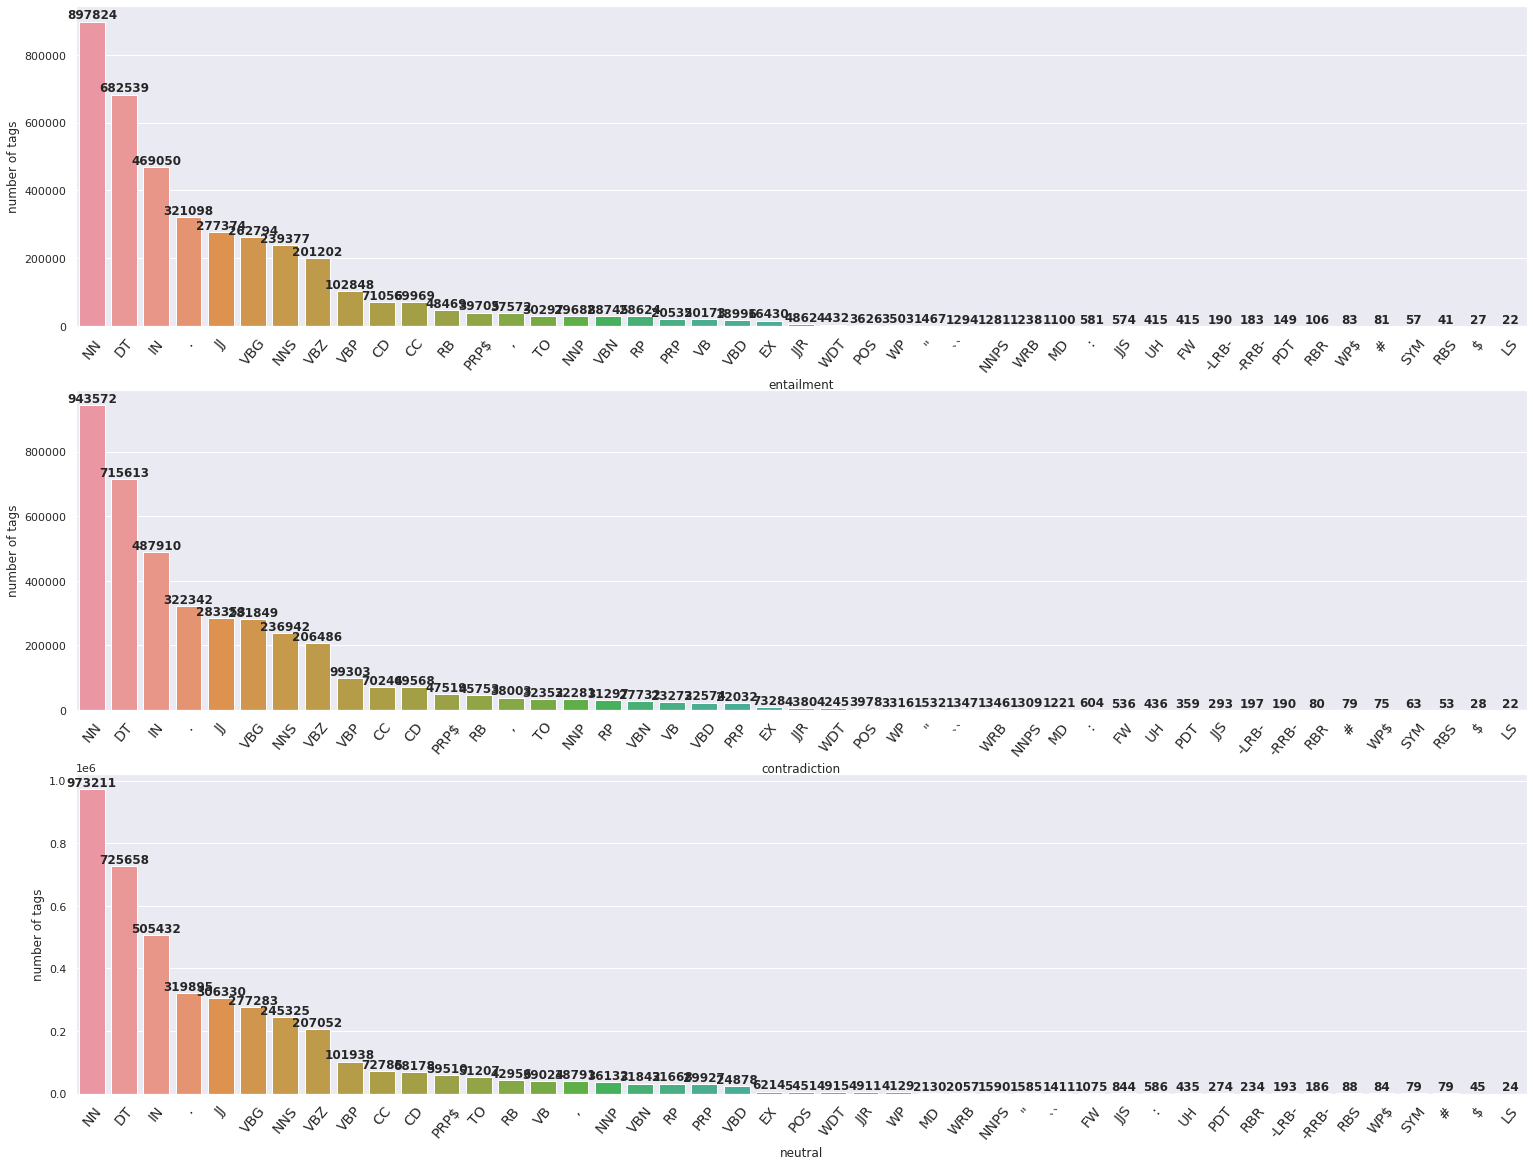

In [30]:
fig = plt.figure(figsize=(26, 20))
fig.subplots_adjust(hspace=0.2)
for tags, class_name, i in zip([e_tags, c_tags, n_tags], ['entailment', 'contradiction', 'neutral'], list(range(3))):
    ax = fig.add_subplot(3, 1, i + 1)
    label, count = tags.value_counts().index, tags.value_counts().values
    ax = sns.barplot(label, count)
    ax.set_xlabel(class_name)
    ax.set_ylabel('number of tags')
    rects = ax.patches
    for rect, label in zip(rects, count):
        rec_height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, rec_height + 5, label, ha='center', va='bottom', fontweight='semibold')
    plt.xticks(rotation=50);
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 

In [31]:
df.head()

,sent1,sent2,sent1_pos,sent2_pos,sent1_tags,sent2_tags,label,label_num
0,a person on a horse jumps over a broken down a...,a person is training his horse for a competition,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,"[DT, NN, IN, DT, NN, VBZ, IN, DT, JJ, JJ, NN, .]","[DT, NN, VBZ, VBG, PRP$, NN, IN, DT, NN, .]",neutral,0
1,a person on a horse jumps over a broken down a...,a person is at a diner ordering an omelette,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,"[DT, NN, IN, DT, NN, VBZ, IN, DT, JJ, JJ, NN, .]","[DT, NN, VBZ, IN, DT, NN, ,, VBG, DT, NN, .]",contradiction,-1
2,a person on a horse jumps over a broken down a...,a person is outdoors on a horse,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,"[DT, NN, IN, DT, NN, VBZ, IN, DT, JJ, JJ, NN, .]","[DT, NN, VBZ, RB, ,, IN, DT, NN, .]",entailment,1
3,children smiling and waving at camera,they are smiling at their parents,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VB...,"[NNP, VBG, CC, VBG, IN, NN]","[PRP, VBP, VBG, IN, PRP$, NNS]",neutral,0
4,children smiling and waving at camera,there are children present,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NN...,"[NNP, VBG, CC, VBG, IN, NN]","[EX, VBP, NNS, RB]",entailment,1


## Feature engineering 

In [32]:
# Features of type 1, BLEU score

smoothie = SmoothingFunction().method1

for df in [X_train, X_dev, X_test]:
    df['bleu_score'] = df.loc[:, ['sent1', 'sent2']].apply(lambda x: sentence_bleu(x.sent1.split(), x.sent2.split(), smoothing_function=smoothie), axis=1)
    

In [33]:
with open('/content/drive/MyDrive/snli_1.0/X_train', 'wb') as f:
    pickle.dump(X_train, f)
with open('/content/drive/MyDrive/snli_1.0/X_dev', 'wb') as f:
    pickle.dump(X_dev, f)
with open('/content/drive/MyDrive/snli_1.0/X_test', 'wb') as f:
    pickle.dump(X_test, f)

In [57]:
with open('/content/drive/MyDrive/snli_1.0/X_train', 'rb') as f:
    X_train = pickle.load(f)
with open('/content/drive/MyDrive/snli_1.0/X_dev', 'rb') as f:
    X_dev = pickle.load(f)
with open('/content/drive/MyDrive/snli_1.0/X_test', 'rb') as f:
    X_test = pickle.load(f)

In [29]:
# Features of type 2, overlap between words in the premise and hypothesis

def get_overlap_coutns(row):
    s1 = set(row.sent1.split())
    s2 = set(row.sent2.split())
    return len(s1.intersection(s2))

def get_overlap_pct(row):
    s1 = len(row.sent1.split())
    s2 = len(row.sent2.split())
    return row.oveplap_counts / max(s1, s2)

for df in [X_train, X_dev, X_test]: 
    df['oveplap_counts'] = df.loc[:, ['sent1', 'sent2']].apply(lambda x: get_overlap_coutns(x), axis=1)
    df['oveplap_pct'] = df.loc[:, ['sent1', 'sent2', 'oveplap_counts']].apply(lambda x: get_overlap_pct(x), axis=1)

In [30]:
# Features of type 3, overlap between nouns, verbs, adjectives, and adverbs in the premise and hypothesis  

tags = ['NN', 'NNP', 'NNPS', 'NNS',
        'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ',
        'JJ', 'JJR', 'JJS',
        'RB', 'RBR', 'RBS']

def get_NVJR_overlap_coutns(row):
    s1_tg1 = [i for i in zip(row.sent1_tags, row.sent1.split()) if i[0] in tags] 
    s2_tg2 = [i for i in zip(row.sent2_tags, row.sent2.split()) if i[0] in tags]
    if s1_tg1 == [] or s2_tg2 == []:
        return 0
    else:
        return len(set(list(zip(*s1_tg1))[1]).intersection(set(list(zip(*s2_tg2))[1])))

def get_NVJR_overlap_pct(row):
    s1_tg1 = [i for i in zip(row.sent1_tags, row.sent1.split()) if i[0] in tags] 
    s2_tg2 = [i for i in zip(row.sent2_tags, row.sent2.split()) if i[0] in tags]
    return row.NVJR_oveplap_counts / max(len(s1_tg1), len(s2_tg2))

for df in [X_train, X_dev, X_test]: 
    df['NVJR_oveplap_counts'] = df.loc[:, ['sent1', 'sent2', 'sent1_tags', 'sent2_tags']].apply(lambda x: get_NVJR_overlap_coutns(x), axis=1)
    df['NVJR_oveplap_pct'] = df.loc[:, ['sent1', 'sent2', 'sent1_tags', 'sent2_tags', 'NVJR_oveplap_counts']].apply(lambda x: get_NVJR_overlap_pct(x), axis=1)

In [31]:
# Features of type 4, indicator for each unigram and bigram in hypothesis 

indicator_vec = CountVectorizer(ngram_range=(1,2), binary=True)
ngrams_train = indicator_vec.fit_transform(X_train.sent2)
ngrams_dev = indicator_vec.transform(X_dev.sent2)
ngrams_test = indicator_vec.transform(X_test.sent2)

In [32]:
# Features of type 5, cross-unigrams 

def build_cross_unigrams(df):
    unigrams = lil_matrix((df.shape[0], len(unique)))
    for i in range(df.shape[0]):
        tags = set(df.sent1_tags[i]).intersection(set(df.sent2_tags[i]))
        l1 = list(zip(df.sent1_tags[i], df.sent1[i].split()))
        l2 = list(zip(df.sent2_tags[i], df.sent2[i].split()))
        for tpl in l1 + l2:
            if tpl[0] in tags:
                try:
                    unigrams[i, vocab[tpl[1]]] = 1
                except:
                    pass
    return unigrams

sent12 = pd.concat([X_train['sent1'], X_train['sent2']], axis=0)
words = " ".join(sent12).split()
unique = set(words)
vocab = dict(zip(unique, range(len(unique))))

cross_unigrams_train = build_cross_unigrams(X_train)
cross_unigrams_dev = build_cross_unigrams(X_dev)
cross_unigrams_test = build_cross_unigrams(X_test)

In [33]:
for df in [X_train, X_dev, X_test]: 
    df['sent1_bigrams'] = df['sent1'].apply(lambda row: list(nltk.ngrams(row.split(), 2)))
    df['sent2_bigrams'] = df['sent2'].apply(lambda row: list(nltk.ngrams(row.split(), 2)))

In [34]:
# Features of type 6, cross-bigrams

start = time.time()
def build_cross_bigrams(df):
    bigrams = lil_matrix((df.shape[0], len(unique)))
    for i in range(df.shape[0]):
        tags = set(df.sent1_tags[i][1:]).intersection(set(df.sent2_tags[i][1:]))
        l1 = list(zip(df.sent1_tags[i][1:], df.sent1_bigrams[i]))
        l2 = list(zip(df.sent2_tags[i][1:], df.sent2_bigrams[i]))
        for tpl in l1 + l2:
            if tpl[0] in tags:
                try:
                    bigrams[i, vocab[tpl[1]]] = 1
                except Exception:
                    pass

    return bigrams

sent12 = pd.concat([X_train['sent1_bigrams'], X_train['sent2_bigrams']], axis=0)
bi_lst = []
for row in sent12:
    bi_lst += row
unique = set(bi_lst)
vocab = dict(zip(unique, range(len(unique))))

cross_bigrams_train = build_cross_bigrams(X_train)
cross_bigrams_dev = build_cross_bigrams(X_dev)
cross_bigrams_test = build_cross_bigrams(X_test)

In [53]:
train_features = hstack([X_train[['bleu_score', 'oveplap_counts', 'oveplap_pct', 'NVJR_oveplap_counts', 'NVJR_oveplap_pct']], 
                         ngrams_train, cross_unigrams_train, cross_bigrams_train])
dev_features = hstack([X_dev[['bleu_score', 'oveplap_counts', 'oveplap_pct', 'NVJR_oveplap_counts', 'NVJR_oveplap_pct']], 
                         ngrams_dev, cross_unigrams_dev, cross_bigrams_dev])
test_features = hstack([X_test[['bleu_score', 'oveplap_counts', 'oveplap_pct', 'NVJR_oveplap_counts', 'NVJR_oveplap_pct']], 
                         ngrams_test, cross_unigrams_test, cross_bigrams_test])

In [36]:
with open('/content/drive/MyDrive/snli_1.0/features_train', 'wb') as f:
    pickle.dump(train_features, f)
with open('/content/drive/MyDrive/snli_1.0/features_dev', 'wb') as f:
    pickle.dump(dev_features, f)
with open('/content/drive/MyDrive/snli_1.0/features_test', 'wb') as f:
    pickle.dump(test_features, f)

In [54]:
with open('/content/drive/MyDrive/snli_1.0/features_train', 'rb') as f:
    train_features = pickle.load(f)
with open('/content/drive/MyDrive/snli_1.0/features_dev', 'rb') as f:
    dev_features = pickle.load(f)
with open('/content/drive/MyDrive/snli_1.0/features_test', 'rb') as f:
    test_features = pickle.load(f)

## ML

Для начала обучим логистическую регрессию с найденными ранее признаками.

In [ ]:
lg = LogisticRegression(C=100.0, multi_class='ovr', max_iter=2000, n_jobs=-1)
lg.fit(train_features, y_train.label)

In [61]:
preds = lg.predict(dev_features)
print("Training accuracy: ", accuracy_score(y_train.label, lg.predict(train_features)))
print("Test accuracy: ", accuracy_score(y_dev.label, preds))

Training accuracy:  0.9645515426104146
Test accuracy:  0.6739483844747003


In [62]:
print("Classification report")
print(classification_report(y_dev.label, preds))

Classification report
               precision    recall  f1-score   support

contradiction       0.67      0.69      0.68      3278
   entailment       0.71      0.70      0.71      3329
      neutral       0.64      0.63      0.64      3235

     accuracy                           0.67      9842
    macro avg       0.67      0.67      0.67      9842
 weighted avg       0.67      0.67      0.67      9842



Text(0.5, 1.0, 'Confusion matrix')

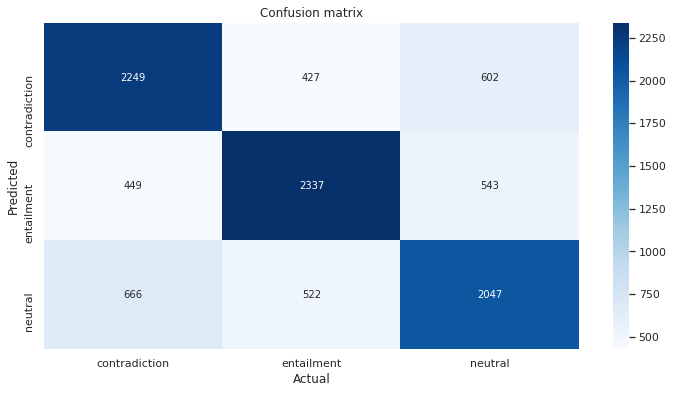

In [64]:
aux_df = y_train[['label', 'label_num']].drop_duplicates().sort_values('label')
conf_matrix = confusion_matrix(y_dev.label, preds)
plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['label'].values, 
            yticklabels=aux_df['label'].values,
            cmap="Blues", 
            fmt="d")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')

Обучим более сложную модель


In [ ]:
!pip install -U sentence-transformers

In [ ]:
!pip install torch==1.7.0

In [36]:
import torch
print(torch.__version__)

1.7.0


In [38]:
import math

from sentence_transformers import SentenceTransformer, models, losses, evaluation, SentencesDataset
from sentence_transformers.readers import InputExample

from torch import nn
from torch.utils.data.dataloader import DataLoader
import torch

In [58]:
train_examples = [InputExample(texts=[X_train.iloc[i,0], X_train.iloc[i,1]], label= y_train.label_num[i]) for i in range(X_train.shape[0])]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

In [67]:
word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=200)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),                                
                              pooling_mode_mean_tokens=True,
                              pooling_mode_cls_token=False,
                              pooling_mode_max_tokens=False)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=word_embedding_model.get_word_embedding_dimension(),\
                                concatenation_sent_rep = True, concatenation_sent_difference = True, num_labels=3)

num_epochs = 1

warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up

# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps = warmup_steps,
          output_path = '/content/drive/MyDrive/snli_1.0/model_sbert1'
         )

In [78]:
model = SentenceTransformer('/content/drive/MyDrive/model_sbert')


In [79]:
cuda1 = torch.device('cuda:0')

In [80]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    self.fc2 = nn.Linear(in_features= 2304, out_features = 3)
    self.activation2 = nn.Softmax()

  def forward(self, input):
    x = self.activation2(self.fc2(input))
    return x

In [81]:
classifier = Classifier().to(cuda1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr= 0.0001)

In [82]:
batch_size = 32
begin_train, end_train = [], []
kolvo_steps = int(X_train.shape[0]/batch_size)
for i in range(1, kolvo_steps + 2):
  begin_train.append((i - 1)*batch_size)
  end_train.append(i*batch_size if i != kolvo_steps + 1 else X_train.shape[0])

In [83]:
X_train_list1 = np.array(X_train.iloc[:,0])
X_train_list2 = np.array(X_train.iloc[:,1])

X_dev_list1 = np.array(X_dev.iloc[:,0])
X_dev_list2 = np.array(X_dev.iloc[:,1])

X_test_list1 = np.array(X_test.iloc[:,0])
X_test_list2 = np.array(X_test.iloc[:,1])

In [84]:
y_train_tensor = torch.LongTensor(y_train.label_num).to(cuda1)
y_dev_tensor = torch.LongTensor(y_dev.label_num).to(cuda1)
y_test_tensor = torch.LongTensor(y_test.label_num).to(cuda1)

In [85]:
import time

t = time.time()
nb_epoch = 1
train_loss_for_epoch = []
test_loss_for_epoch = []
for epoch in range(1, nb_epoch + 1):
    t_for_epoch = time.time()
    train_loss = 0
    test_loss = 0
    random_sample = np.random.permutation(range(X_train.shape[0]))
    for i in range(len(begin_train)):
        optimizer.zero_grad()
        indices = random_sample[begin_train[i]: end_train[i]]
        sent1 = model.encode(X_train_list1[indices])
        sent2 = model.encode(X_train_list2[indices])
        input = torch.Tensor(np.concatenate((sent1 , sent2, np.abs(sent1 - sent2)), axis = 1)).to(cuda1)
        output = classifier(input.to(cuda1)).to(cuda1)
        loss = criterion(output,  y_train_tensor[indices])
        loss.backward() 
        train_loss += loss.data.item()
        optimizer.step()
        torch.cuda.empty_cache()
        if i % 3000 == 0:
            print(i, " ",(time.time() - t)/60, " ", loss.data.item())
    print(f"epoch: {epoch}, train loss: {train_loss/len(begin_train)}")
    random_sample = np.random.permutation(range(X_train.shape[0]))[:50000]
    train1, train2 = model.encode(X_train_list1[random_sample]), model.encode(X_train_list2[random_sample])
    input = torch.Tensor(np.concatenate((train1 , train2, np.abs(train1 - train2)), axis = 1)).to(cuda1)
    output = torch.max(classifier(input), 1)[1]
    train_acc = (y_train_tensor[random_sample] == output).sum()/ len(output)
    print(f"epoch: {epoch}, train accuracy: {train_acc}")
    dev1, dev2 = model.encode(X_dev_list1), model.encode(X_dev_list2)
    input = torch.Tensor(np.concatenate((dev1 , dev2, np.abs(dev1 - dev2)), axis = 1)).to(cuda1)
    output = torch.max(classifier(input), 1)[1]
    test_acc = (y_dev_tensor == output).sum()/ len(output)
    print(f"epoch: {epoch}, test accuracy: {test_acc}")
    t1 = time.time()

0   0.010163172086079916   1.0768685340881348
3000   6.512839925289154   0.7024838328361511
6000   12.998355249563852   0.6704823970794678
9000   19.49290521542231   0.771217942237854
12000   25.99430222113927   0.6520623564720154
15000   32.466770688692726   0.6129624247550964
epoch: 1, train loss: 0.7016028037810315
epoch: 1, train accuracy: 0.8613199591636658
epoch: 1, test accuracy: 0.8460678458213806


In [86]:
dev1, dev2 = model.encode(X_dev_list1), model.encode(X_dev_list2)
input1 = torch.Tensor(np.concatenate((dev1 , dev2, np.abs(dev1 - dev2)), axis = 1)).to(cuda1)
res_neurons = classifier(input1)
output = torch.max(res_neurons, 1)[1]
dev_acc = (y_dev_tensor == output).sum()/ len(output)

In [87]:
dev_acc

tensor(0.8461, device='cuda:0')

In [88]:
res_neurons = res_neurons.cpu().detach().numpy()
output = output.cpu().detach().numpy()
y_dev_tensor = y_dev_tensor.cpu().detach().numpy()

Text(0.5, 1.0, 'Confusion matrix')

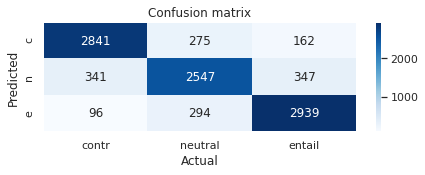

In [90]:
conf_matrix = confusion_matrix(y_dev.label_num, output)
plt.figure(figsize=(7, 2))
sns_plot = sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels = ['contr', 'neutral', 'entail'],
            yticklabels = ['c', 'n', 'e'],
            cmap = 'Blues', fmt="d")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')

In [102]:
print(classification_report(y_dev_tensor, output))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3278
           1       0.82      0.79      0.80      3235
           2       0.85      0.88      0.87      3329

    accuracy                           0.85      9842
   macro avg       0.85      0.85      0.85      9842
weighted avg       0.85      0.85      0.85      9842



Для каждого класса считаем процент примеров, у которых неправильно предсказан данный класс, но вероятность выбора правильного класса стоит на втором месте

In [104]:
[np.mean((np.argsort(res_neurons[(output != i) & (y_dev_tensor == i)], axis = 1)[:, 1] == i)) for i in range(3)]

[0.6270022883295194, 0.9084302325581395, 0.7205128205128205]

Как можно увидеть из результатов, алгоритм "понимает", что класс 1 находится где-то между остальными двумя.